# Quantification des incertitudes - Solution


In [1]:
import numpy as np
import openturns as ot

In [2]:
data = ot.Sample.ImportFromCSVFile("sample_E.csv")
data.setDescription(["Young Modulus"])
n = data.getSize()
print("Sample size=%d" % (n))

Sample size=229


In [3]:
data[0:10]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=10 dimension=1 description=[Young Modulus] data=[[2.99532e+07],[2.86804e+07],[3.06412e+07],[3.2051e+07],[3.77857e+07],[3.79726e+07],[3.70693e+07],[3.01798e+07],[3.72172e+07],[2.92682e+07]]

## Question 1 : statistiques descriptives

- Calculer les principales caractéristiques de l'échantillon: moyenne, écart-type, médiane, minimum, maximum, intervalle inter-quartiles (i.e. à 25% et 75%)

## Solution de la question 1 : statistiques descriptives


In [4]:
sample_size = data.getSize()
sample_mean = data.computeMean()[0]
sample_std = data.computeStandardDeviation()[0]
sample_median = data.computeQuantile(0.5)[0]
sample_q1 = data.computeQuantile(0.25)[0]
sample_q3 = data.computeQuantile(0.75)[0]
sample_min = data.getMin()[0]
sample_max = data.getMax()[0]
print(" Size     = %d" % sample_size)
print(" Mean     = %.4g MPa" % (sample_mean / 1.0e6))
print(" St. dev. = %.4g MPa" % (sample_std / 1.0e6))
print(" Median   = %.4g MPa" % (sample_median / 1.0e6))
print(" Q1, Q3   = [%.4g, %.4g] MPa" % (sample_q1 / 1.0e6, sample_q3 / 1.0e6))
print(" Range    = [%.4g, %.4g] MPa" % (sample_min / 1.0e6, sample_max / 1.0e6))

 Size     = 229
 Mean     = 33.87 MPa
 St. dev. = 4.545 MPa
 Median   = 33.09 MPa
 Q1, Q3   = [29.87, 36.9] MPa
 Range    = [28.01, 48.12] MPa


## Question 2 : histogramme empirique

- Utiliser la classe `HistogramFactory` pour dessiner l'histogramme empirique de l'échantillon.

## Solution de la question 2 : histogramme empirique

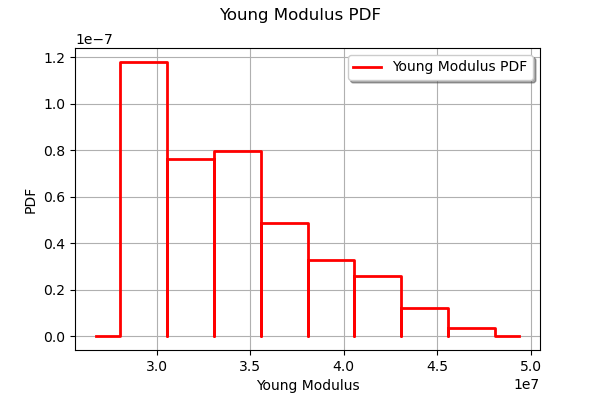

In [5]:
ot.HistogramFactory().build(data).drawPDF()

## Question 3 : ajuster une loi beta

* Utiliser la classe `BetaFactory` pour estimer les paramètres de la loi Beta s'ajustant au données. 
* Dessiner la PDF de cette loi ajustée.
* Afficher les paramètres estimés.

## Solution de la question 3 : ajuster une loi beta

Let us first estimate a `Beta`distribution:

In [6]:
E = ot.BetaFactory().build(data)
E

class=Beta name=Beta dimension=1 alpha=0.91834 beta=2.21034 a=2.79215e+07 b=4.82022e+07

La méthode `build()` retourne une instance de la classe `Distribution`. 

In [7]:
type(E)

openturns.model_copula.Distribution

Si on souhaite obtenir une instance de la classe `Beta`, on utilise la méthode `buildAsBeta()`. 

In [8]:
E = ot.BetaFactory().buildAsBeta(data)
print(E)
print(type(E))

Beta(alpha = 0.91834, beta = 2.21034, a = 2.79215e+07, b = 4.82022e+07)
<class 'openturns.dist_bundle1.Beta'>


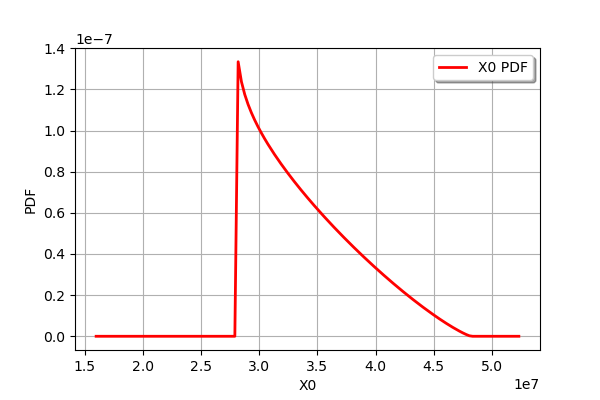

In [9]:
E.drawPDF()

In [10]:
E.getParametersCollection()[0]

class=PointWithDescription name=X0 dimension=4 description=[alpha,beta,a,b] values=[0.91834,2.21034,2.79215e+07,4.82022e+07]

## Question 4 : réaliser le test de Kolmogorov-Smirnov

- Utiliser la classe `FittingTest.Kolmogorov` pour réaliser le test de Kolmogorov-Smirnov. 
- Calculer la p-valeur.
- Doit-on rejeter la loi beta ou non ?

## Solution de la question 4 : réaliser le test de Kolmogorov-Smirnov

Puisque les paramètres ont étés estimés sur l'échantillon, il faut utiliser la classe `Lilliefors` fondée sur une `Factory`.

In [11]:
betafact = ot.BetaFactory()
fitted_dist, test_result = ot.FittingTest.Lilliefors(data, betafact)
fitted_dist

class=Beta name=Beta dimension=1 alpha=0.91834 beta=2.21034 a=2.79215e+07 b=4.82022e+07

In [12]:
test_result.getPValue()

0.7615421227986673

In [13]:
test_result.getThreshold()

0.05

In [14]:
test_result.getBinaryQualityMeasure()

True

La p-valeur est égale à 0.7615, ce qui implique que la distribution Beta ne peut pas être rejetée.

## Question 5 : QQ-plot

- Utiliser la classe `VisualTest_DrawQQplot` pour dessiner le qq-plot. 
- L'ajustement est-il satisfaisant ?

## Solution de la question 5 : QQ-plot

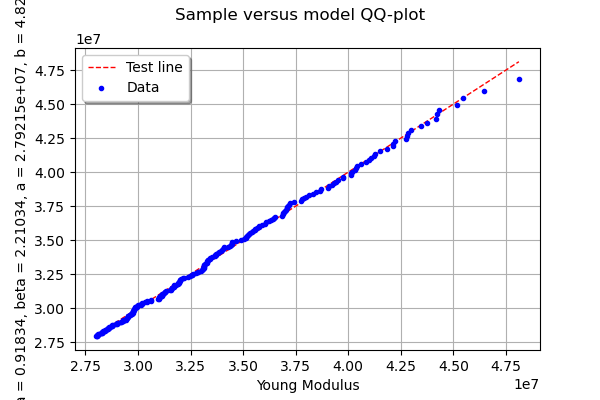

In [15]:
ot.VisualTest.DrawQQplot(data, E)

On constate que l'ajustement est satisfaisant, à l'exception peut-être des valeurs les plus grandes de $E$. 

## Solution de la question 6 : sélection de modèle par le critère BIC

In [16]:
bic = ot.FittingTest.BIC(data, E)
bic

33.11173911943841

In [17]:
for factory in [
    ot.UniformFactory(),
    ot.NormalFactory(),
    ot.BetaFactory(),
    ot.LogNormalFactory(),
    ot.TruncatedNormalFactory()
]:
    distribution = factory.build(data)
    name = distribution.getName()
    numberOfEstimatedParameters = distribution.getParameterDimension()
    bic = ot.FittingTest.BIC(data, distribution, numberOfEstimatedParameters)
    print("%s : %.4f" % (name, bic))

Uniform : 33.6978
Normal : 33.5401
Beta : 33.2067
LogNormal : 33.4291
TruncatedNormal : 33.1731


WRN - Error: cannot estimate a LogNormal distribution based on the given sample using the method of local maximum likelihood, probably because the sample is constant.


Echoue avec boost : https://github.com/openturns/openturns/issues/1331

In [18]:
tested_factory_list = ot.DistributionFactory().GetContinuousUniVariateFactories()
len(tested_factory_list)

31

Une alternative consiste à utiliser la méthode statique `BestModelBIC`, qui retourne le meilleur modèle. 

In [19]:
dist, test_result = ot.FittingTest.BestModelBIC(data, tested_factory_list)
print(dist)
print(test_result)

TruncatedNormal(mu = 2.32583e+07, sigma = 9.58852e+06, a = 2.79646e+07, b = 4.81591e+07)
33.17310847884099


WRN - Warning! Impossible to use factory ChiFactory. Reason=InvalidArgumentException : Error: cannot estimate parameters of a Chi distribution from the given sample
WRN - Warning! Impossible to use factory DirichletFactory. Reason=InvalidArgumentException : Error: the sample contains points not in the unit simplex: x=class=Point name=Unnamed dimension=1 values=[2.99532e+07]
WRN - Warning! Impossible to use factory FisherSnedecorFactory. Reason=InvalidArgumentException : Error d1 of a FisherSnedecor distribution must be positive
WRN - Error: cannot estimate a LogNormal distribution based on the given sample using the method of local maximum likelihood, probably because the sample is constant.
WRN - Warning! Impossible to use factory MeixnerDistributionFactory. Reason=InvalidArgumentException : Error: cannot estimate a MeixnerDistribution distribution if the sample kurtosis=2.89011 is not greater than 2*skewness^2+3=4.27797
WRN - Warning! Impossible to use factory TriangularFactory. Reas

In [20]:
print(test_result)

33.17310847884099


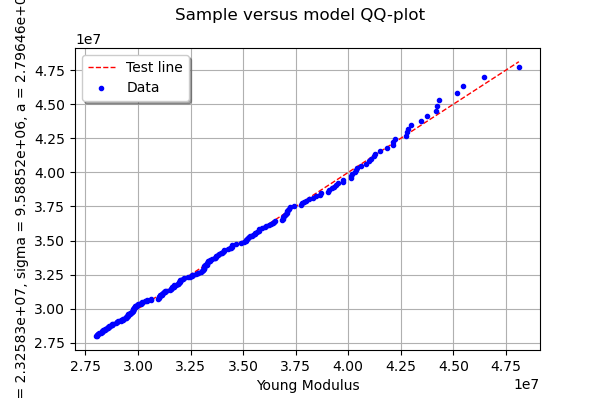

In [21]:
ot.VisualTest.DrawQQplot(data, dist)

On observe que la loi log-normale s'ajuste plutôt bien aux données, à l'exception peut-être des valeurs les plus grandes de $E$. 

## Question 7 : histogramme

- Utiliser la classe `HistogramFactory` pour créer la distribution de type histogramme qui s'ajuste aux données. 
- Utiliser le QQ-plot pour valider graphiquement cette distribution. 
- Quelle est la limite de cette technique ?
- L'histogramme est-il une distribution satisfaisante de ce cas particulier ? Dans quel type d'études cette méthode pourrait convenir ?

## Solution de la question 7 : histogramme


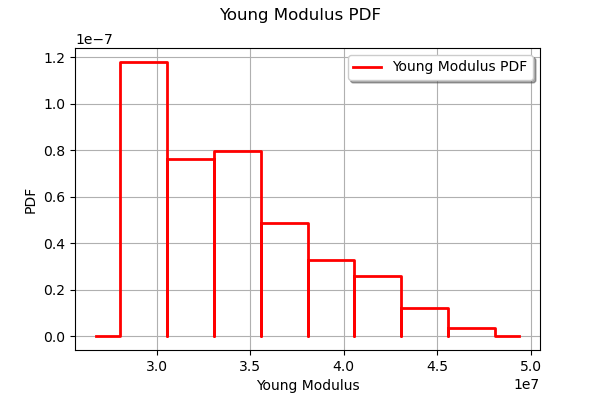

In [22]:
histogram = ot.HistogramFactory().build(data)
histogram.drawPDF()

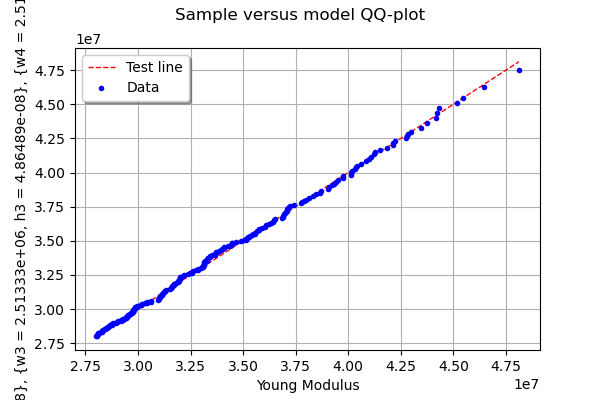

In [23]:
ot.VisualTest.DrawQQplot(data, histogram)

On observe que l'histogramme est plutôt satisfaisant, pour toutes les valeurs de l'échantillon. 

L'histogramme est une méthode intéressante, mais ne permet pas de générer des valeurs qui sont au-delà de l'échantillon. 

C'est une méthode qui peut être intéressante lorsqu'on dispose de beaucoup de données ou bien que l'étude est plutôt une étude de type tendance centrale. Si, au contraire, on possède peu de données ou bien que l'on s'intéresse aux extrêmes, alors l'histogramme ne peut pas convenir.

## Question 8 : méthode à noyau

- Utiliser la classe `KernelSmoothing` pour utiliser une méthode à noyau pour estimer la distribution. 
- Utiliser le QQ-Plot pour valider le résultat graphiquement.

## Solution de la question 8 : méthode à noyau

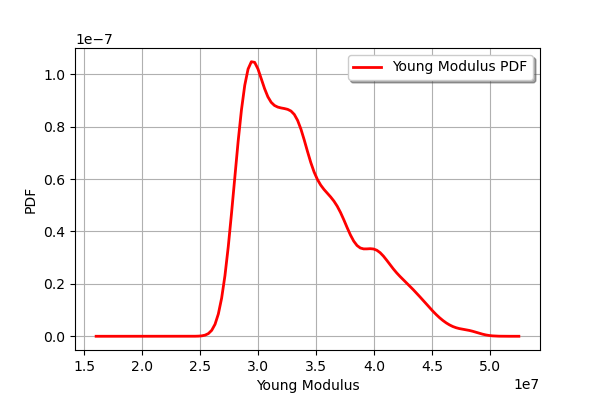

In [24]:
ks = ot.KernelSmoothing().build(data)

ks.drawPDF()

## Question 9 : synthèse

On souhaite comparer les trois distributions suivantes :
- la distribution Beta 
- la distribution issue de l'estimation à noyau 
- l'histogramme empirique

Comparer ces distributions du point de vue de la PDF : 
- quelles différences observez-vous ?
- quelle semble être la loi la plus appropriée ?

## Solution de la question 9 : synthèse

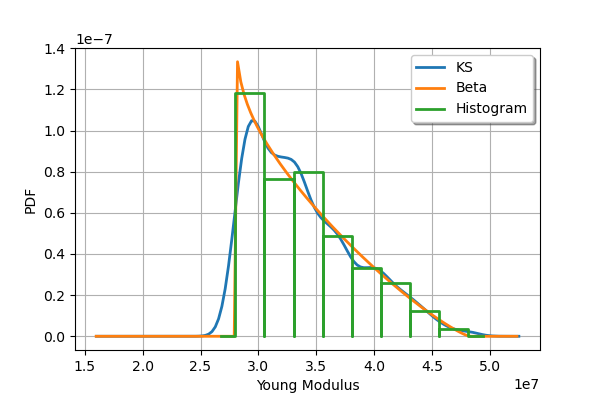

In [25]:
K = ot.KernelSmoothing().build(data)
graphks = K.drawPDF()
graphks.setLegends(["KS"])
#
E = ot.BetaFactory().build(data)
graphE = E.drawPDF()
graphE.setLegends(["Beta"])
#
H = ot.HistogramFactory().build(data)
graphH = H.drawPDF()
graphH.setLegends(["Histogram"])
#
graphks.add(graphE)
graphks.add(graphH)
graphks.setColors(ot.Drawable.BuildDefaultPalette(3))
graphks

On observe que la loi fondée sur l'estimation à noyau est moins régulière. On observe qu'ele est susceptible de générer des valeurs inférieures à $E=28 \times 10^6$, alors qu'aucune donnée de ce type ne figure dans l'échantillon.

De toute évidence, c'est la loi Beta qui s'ajuste le mieux à ces données.